In [6]:
import sys, os
from pathlib import Path
import json
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import adjusted_rand_score as ARI
import pickle

# ensure project root on path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
	sys.path.insert(0, project_root)

# imports from src
from src.twsbm import TWSBM
from src.transformations import *

# load real-world dataset
def load_dataset(key, base_dir="data"):
	folder = Path(base_dir) / key
	meta = json.load(open(folder / "metadata.json"))
	if meta.get("sparse", False):
		A = sp.load_npz(folder / "adjacency.npz")
	else:
		A = np.load(folder / "adjacency.npy")
	Z = np.load(folder / "labels.npy")
	return A, Z, meta

# define transform families
TRANSFORMS = {
	'classical': [
		IdentityTransform(), OppositeTransform(), LogTransform(),
		RankTransform(), QuantileTransform(q=0.1), PowerTransform(γ=1.41)
	],
	'qtl_05': [QuantileTransform(q) for q in np.linspace(0.01, 0.5, 5)],
	'qtl_10': [QuantileTransform(q) for q in np.linspace(0.01, 0.5, 10)],
	'pow_05': [PowerTransform(p) for p in np.linspace(0.5, 2, 5)],
	'pow_10': [PowerTransform(p) for p in np.linspace(0.5, 2, 10)]
}

# collect ARI and embedding stats for a single real-world graph and a transform list
def collect_aris_real(A, Z, K, transforms):
	records = []
	for idx, t in enumerate(transforms):
		A_t = t(A)
		twsbm = TWSBM(A=A_t, Z=Z, K=K, q_outliers=0, transformation=t)
		records.append({
			'transform_idx': idx,
			'transform_name': str(t),
			'ARI': twsbm.ARI,
			'gC_hat': twsbm.gĈ_embed,
			'X_A': twsbm.X_A
		})
	return pd.DataFrame.from_records(records)

# compute summary statistics per transform family
def get_stats_real(df, Z, K):
	stats = {}
	stats['Max'] = df['ARI'].max()
	# ARI at transform that maximizes gC_hat
	best_idx = df['gC_hat'].idxmax()
	stats['Max Ĉ'] = df.loc[best_idx, 'ARI']
	stats['Mean'] = df['ARI'].mean()
	stats['Median'] = df['ARI'].median()
	# Stacked embedding: concatenate and cluster
	X_list = df['X_A'].tolist()
	X_stacked = np.concatenate(X_list, axis=1)
	GMM = TWSBM.fit_gmm(X_stacked, K=K, q_outliers=0)
	Z_hat, *_ = TWSBM.get_gmm_estimates(GMM, X_stacked)
	stats['Stacked'] = ARI(Z, Z_hat)
	return stats

# heatmap plotting function
def plot_heatmap(key, stats_dict, n, K, baseline_ARI):
	families = list(stats_dict.keys())
	metrics = ['Max', 'Max Ĉ', 'Stacked', 'Mean', 'Median']
	orig_data = np.array([
		[stats_dict[fam][met] for fam in families]
		for met in metrics
	], dtype=float)
	diff_data = orig_data - orig_data[0, :]
	cmap = LinearSegmentedColormap.from_list('red_white_green', ['red', 'white', 'green'])
	max_abs = np.max(np.abs(diff_data))

	fig, ax = plt.subplots(figsize=(8, 6))
	im = ax.imshow(diff_data, cmap=cmap, vmin=-max_abs, vmax=max_abs, aspect='auto')

	ax.set_xticks(np.arange(len(families)))
	ax.set_xticklabels(families, rotation=45, ha='right')
	ax.set_yticks(np.arange(len(metrics)))
	ax.set_yticklabels(metrics)

	for i, met in enumerate(metrics):
		for j, fam in enumerate(families):
			weight = 'bold' if met == 'Max' else 'normal'
			ax.text(j, i, f"{orig_data[i, j]:.3f}", ha='center', va='center', fontweight=weight)

	ax.axhline(y=0.5, color='black', linewidth=2)
	ax.set_title(
		f"ARI heatmap for dataset: {key.replace('_', ' ')}\n"
		f"n = {n}, K = {K}, Baseline ARI = {baseline_ARI:.3f}\n"
	)
	cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
	cbar.set_label('Metric − Max', rotation=270, labelpad=15)
	ax.set_xlabel('Transform Families')
	plt.tight_layout()
	plt.show()

In [ ]:
# main loop
base_dir = Path(project_root) / 'data' / 'raw' / 'real_world_graphs'
out_dir  = Path(project_root) / 'data' / 'processed' / 'real_world_graphs'
out_dir.mkdir(parents=True, exist_ok=True)

for ds_folder in base_dir.iterdir():
	if not ds_folder.is_dir():
		continue
	key = ds_folder.name
	print(f"Processing dataset: {key}")
	A, Z, meta = load_dataset(key, base_dir=base_dir) #type: ignore
	K = len(np.unique(Z))
	n = A.shape[0]
	baseline_ARI = TWSBM(A=A, Z=Z, K=K, q_outliers=0).ARI

	stats_dict = {}
	for fam_id, transforms in TRANSFORMS.items():
		print(f"  Family: {fam_id}")
		df = collect_aris_real(A, Z, K, transforms)
		stats_dict[fam_id] = get_stats_real(df, Z, K)

	result = {
		'stats_dict': stats_dict,
		'n': n,
		'K': K,
		'baseline_ARI': baseline_ARI
	}
	with open(out_dir / f"{key}.pkl", 'wb') as f:
		pickle.dump(result, f)

Skipping dataset: cifar10
Skipping dataset: fashionmnist
Processing dataset: high_school_2011
  Family: classical
  Family: qtl_05
  Family: qtl_10
  Family: pow_05
  Family: pow_10
Processing dataset: high_school_2012
  Family: classical
  Family: qtl_05
  Family: qtl_10
  Family: pow_05
  Family: pow_10
Processing dataset: high_school_2013
  Family: classical
  Family: qtl_05
  Family: qtl_10
  Family: pow_05
  Family: pow_10
Skipping dataset: mnist
Processing dataset: primary_school
  Family: classical
  Family: qtl_05
  Family: qtl_10
  Family: pow_05
  Family: pow_10
Processing dataset: workplace_2013
  Family: classical
  Family: qtl_05
  Family: qtl_10
  Family: pow_05
  Family: pow_10
Processing dataset: workplace_2015
  Family: classical
  Family: qtl_05
  Family: qtl_10
  Family: pow_05
  Family: pow_10


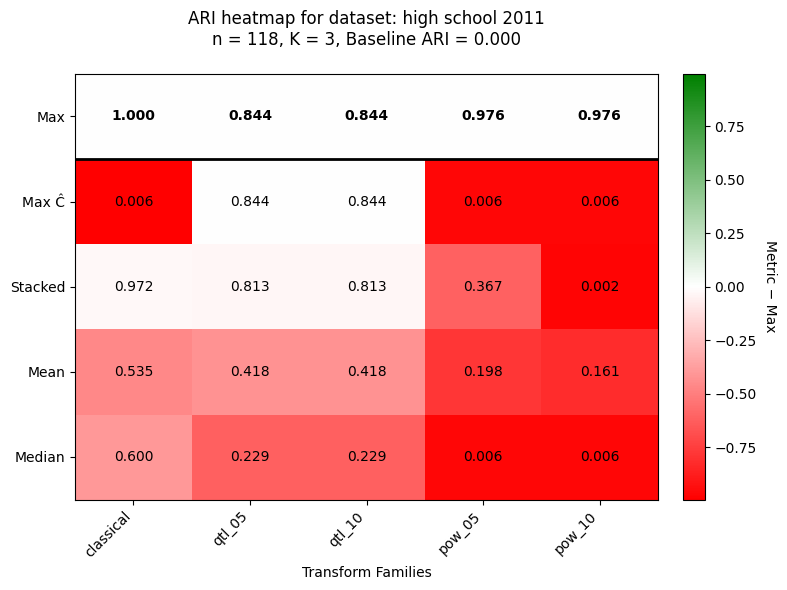

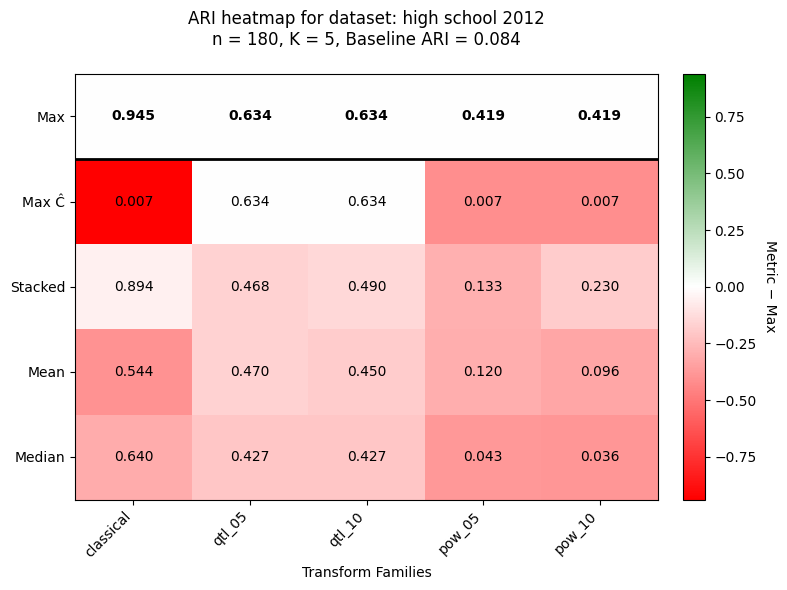

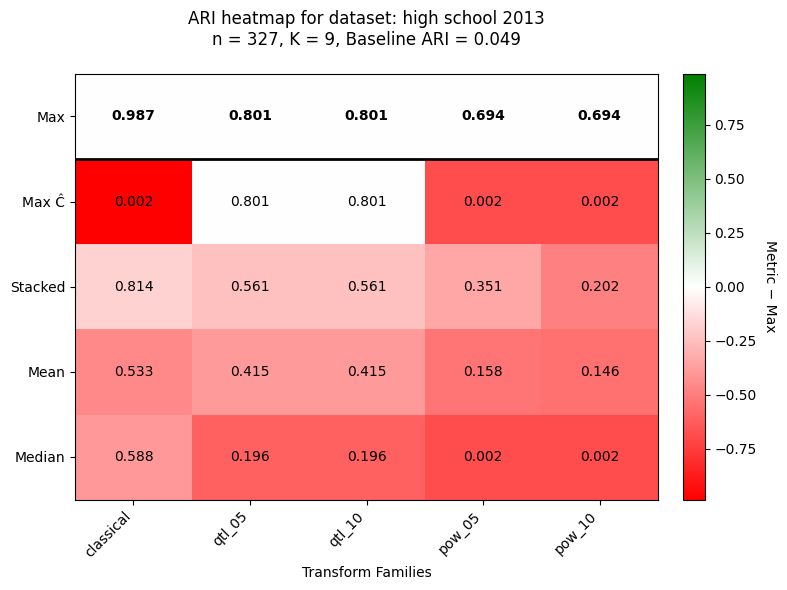

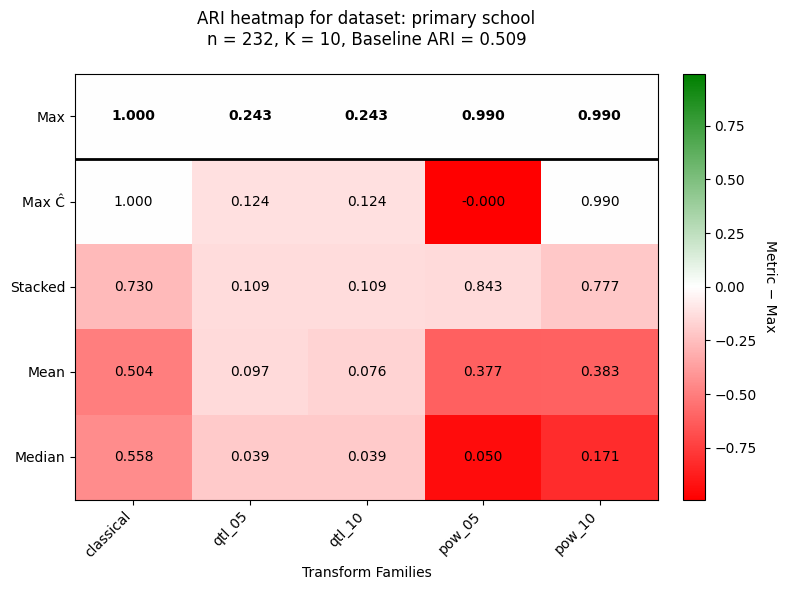

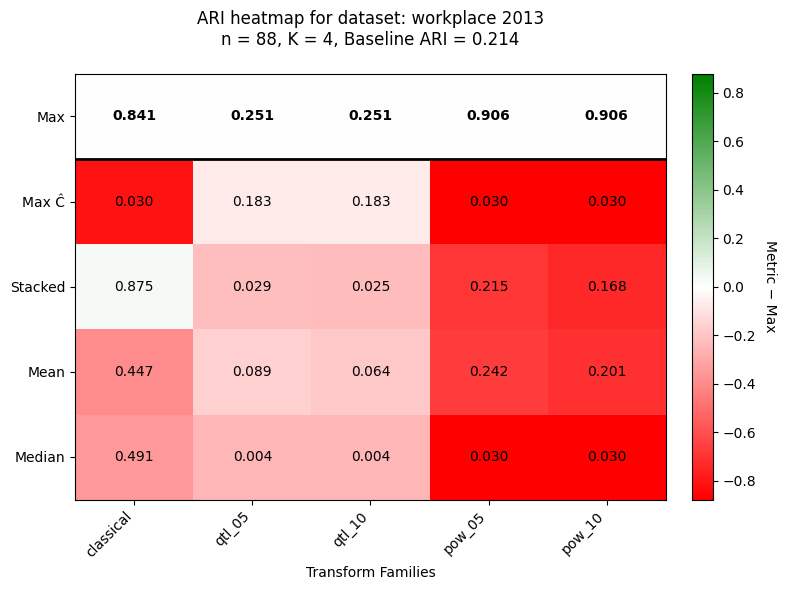

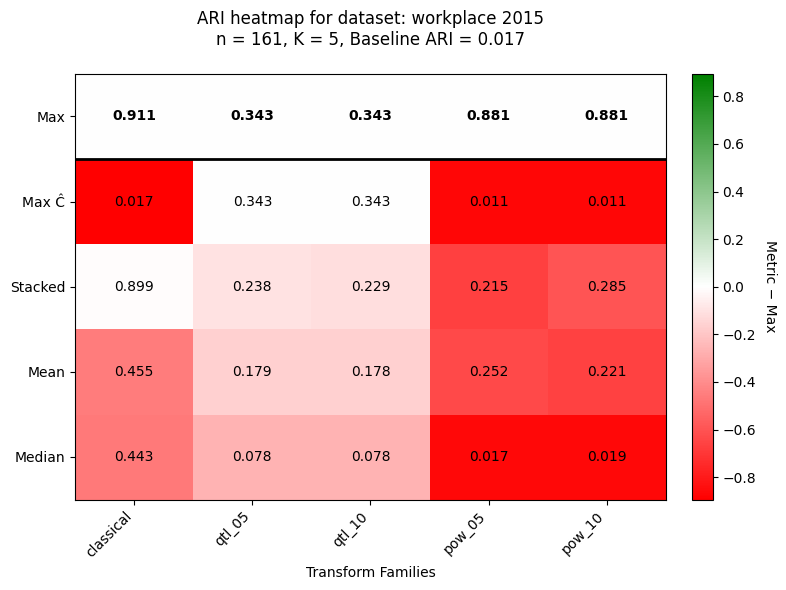

In [7]:
for file in out_dir.glob('*.pkl'):
        key = file.stem
        with open(file, 'rb') as f:
            data = pickle.load(f)
        stats_dict = data['stats_dict']
        n = data['n']
        K = data['K']
        baseline_ARI = data['baseline_ARI']

        plot_heatmap(key, stats_dict, n, K, baseline_ARI)